In [1]:
import pandas as pd
import numpy as np
import time
import os, psutil
import pickle
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default='plotly_mimetype'

def printmem():
    process = psutil.Process(os.getpid())
    print("   memory:",round(process.memory_info().rss/(10**9),3),'Gbytes')  # in bytes 

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from tabulate import tabulate

from keras import models
from keras import layers

In [2]:
df = pd.read_csv('train_expand_S_P.zip')
df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,E_0,E_1,E_10,E_100,...,E_98,E_99,E_132,E_134,E_136,E_56,E_58,E_59,severity,pathoClass
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumo...",M,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...",E_91,0,0,0,0,...,0,0,-1,-1,-1,4,3,3,5,0
1,21,"[['HIV (initial infection)', 0.518950056440760...",M,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_...",E_50,0,0,0,0,...,0,0,0,6,0,7,7,2,3,1
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumo...",F,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55...",E_77,0,0,0,0,...,0,0,4,0,0,5,2,6,3,2
3,34,"[['URTI', 0.23859396799565236], ['Cluster head...",F,URTI,"['E_48', 'E_53', 'E_54_@_V_183', 'E_55_@_V_89'...",E_53,0,0,0,0,...,0,0,-1,-1,-1,7,5,4,5,0
4,36,"[['URTI', 0.23677812769175735], ['Influenza', ...",M,URTI,"['E_49', 'E_50', 'E_53', 'E_54_@_V_183', 'E_55...",E_201,0,0,0,0,...,0,0,-1,-1,-1,5,4,2,5,0


In [6]:
cols_num = ['E_132', 'E_134', 'E_136', 'E_56', 'E_58', 'E_59']

In [29]:
# adjust range of numerical values
df[cols_num] = df[cols_num].apply(lambda val: val/10).replace(-0.1, -1)

In [30]:
dicMW = {'M': 0, 'F':1}    

In [32]:
df['SEX'] = df['SEX'].map(dicMW)

In [33]:
df.head()

,AGE,DIFFERENTIAL_DIAGNOSIS,SEX,PATHOLOGY,EVIDENCES,INITIAL_EVIDENCE,E_0,E_1,E_10,E_100,...,E_98,E_99,E_132,E_134,E_136,E_56,E_58,E_59,severity,pathoClass
0,18,"[['Bronchitis', 0.19171203430383882], ['Pneumo...",0,URTI,"['E_48', 'E_50', 'E_53', 'E_54_@_V_161', 'E_54...",E_91,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.4,0.3,0.3,5,0
1,21,"[['HIV (initial infection)', 0.518950056440760...",0,HIV (initial infection),"['E_9', 'E_27', 'E_50', 'E_51', 'E_53', 'E_54_...",E_50,0,0,0,0,...,0,0,0.0,0.6,0.0,0.7,0.7,0.2,3,1
2,19,"[['Bronchitis', 0.11278064619119596], ['Pneumo...",1,Pneumonia,"['E_53', 'E_54_@_V_179', 'E_54_@_V_192', 'E_55...",E_77,0,0,0,0,...,0,0,0.4,0.0,0.0,0.5,0.2,0.6,3,2
3,34,"[['URTI', 0.23859396799565236], ['Cluster head...",1,URTI,"['E_48', 'E_53', 'E_54_@_V_183', 'E_55_@_V_89'...",E_53,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.7,0.5,0.4,5,0
4,36,"[['URTI', 0.23677812769175735], ['Influenza', ...",0,URTI,"['E_49', 'E_50', 'E_53', 'E_54_@_V_183', 'E_55...",E_201,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.5,0.4,0.2,5,0


In [35]:
cols_to_exclude = ['DIFFERENTIAL_DIAGNOSIS', 'PATHOLOGY', 'EVIDENCES', 'INITIAL_EVIDENCE']
df = df.loc[:, [col for col in df.columns if col not in cols_to_exclude]]

In [37]:
df_sample = df.sample(n=50000, random_state=42)
X = df_sample.iloc[:, 0:-2].to_numpy()

In [38]:
y = df_sample['severity'].values
labels=[1,2,3,4,5]
num_classes = len(labels)

In [60]:
y -= 1 # loss function expected labels in range [0,5), so changing range from 0 to 4 instead of 1 to 5 was easiest fix

In [61]:
max(y)

4

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [46]:
X.shape

(10000, 462)

## CNN

In [51]:
#
# Your code for defining the model
#
# Define a sequential model as usual
model_cnn = models.Sequential()
# 
# Our first layer gets the input from our samples - this is 80 time steps by 3 channels
model_cnn.add(layers.Conv1D(100, 10, activation='relu', input_shape=(462,1)))
#
# Anoth convolutional layer
model_cnn.add(layers.Conv1D(100, 10, activation='relu'))
#
# Max pooling 
model_cnn.add(layers.MaxPooling1D(3))
#
# Two more convolutional layers
model_cnn.add(layers.Conv1D(80, 10, activation='relu'))
model_cnn.add(layers.Conv1D(80, 10, activation='relu'))
#
# Global average pooling use this instead of "Flatten" - it helps reduce overfitting
model_cnn.add(layers.GlobalAveragePooling1D())
#model_m.add(Flatten())

model_cnn.add(layers.Dropout(0.5))

model_cnn.add(layers.Dense(num_classes, activation='softmax'))
print(model_cnn.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 453, 100)          1100      
                                                                 
 conv1d_5 (Conv1D)           (None, 444, 100)          100100    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 148, 100)         0         
 1D)                                                             
                                                                 
 conv1d_6 (Conv1D)           (None, 139, 80)           80080     
                                                                 
 conv1d_7 (Conv1D)           (None, 130, 80)           64080     
                                                                 
 global_average_pooling1d_1   (None, 80)               0         
 (GlobalAveragePooling1D)                             

In [52]:
from tensorflow import keras

In [57]:
y_test.shape

(2000,)

In [63]:
patience = 5
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model_cnn01.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience)
]

model_cnn.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 100
EPOCHS = 20

#
# Now fit
history = model_cnn.fit(X_train,y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=(X_test, y_test),
                      verbose=1)
print("Done!")
best_val_acc =  max(history.history['val_accuracy'])
print("Best validation accuracy is:",best_val_acc)

Epoch 1/20
80/80 [==============================] - 9s 108ms/step - loss: 1.5045 - accuracy: 0.3103 - val_loss: 1.4622 - val_accuracy: 0.3090
Epoch 2/20
80/80 [==============================] - 8s 106ms/step - loss: 1.4725 - accuracy: 0.3109 - val_loss: 1.4112 - val_accuracy: 0.2885
Epoch 3/20
80/80 [==============================] - 8s 107ms/step - loss: 1.3798 - accuracy: 0.3716 - val_loss: 1.2841 - val_accuracy: 0.4405
Epoch 4/20
80/80 [==============================] - 9s 108ms/step - loss: 1.2694 - accuracy: 0.4486 - val_loss: 1.1402 - val_accuracy: 0.5665
Epoch 5/20
80/80 [==============================] - 8s 106ms/step - loss: 1.1106 - accuracy: 0.5426 - val_loss: 0.9235 - val_accuracy: 0.6680
Epoch 6/20
80/80 [==============================] - 9s 107ms/step - loss: 0.9290 - accuracy: 0.6363 - val_loss: 0.7383 - val_accuracy: 0.7480
Epoch 7/20
80/80 [==============================] - 9s 107ms/step - loss: 0.7191 - accuracy: 0.7358 - val_loss: 0.5243 - val_accuracy: 0.8280
Epoch 

Number of iterations: 20


,accuracy,loss,val_accuracy,val_loss,iteration
0,0.310250,1.504513,0.309000,1.462250,0
1,0.310875,1.472474,0.288500,1.411178,1
2,0.371625,1.379806,0.440500,1.284141,2
3,0.448625,1.269372,0.566500,1.140183,3
4,0.542625,1.110571,0.668000,0.923483,4
5,0.636250,0.928986,0.748000,0.738330,5
6,0.735750,0.719066,0.828000,0.524300,6
7,0.785875,0.598642,0.867000,0.413926,7
8,0.817250,0.516720,0.785000,0.549404,8
9,0.839250,0.462280,0.914500,0.299243,9


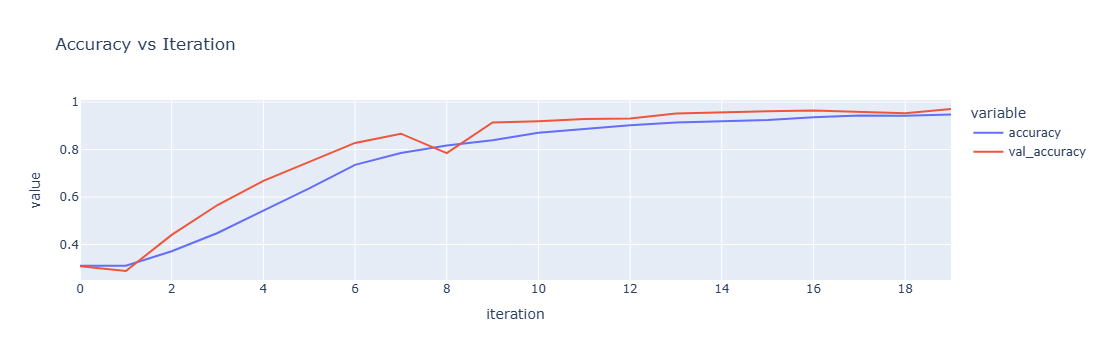

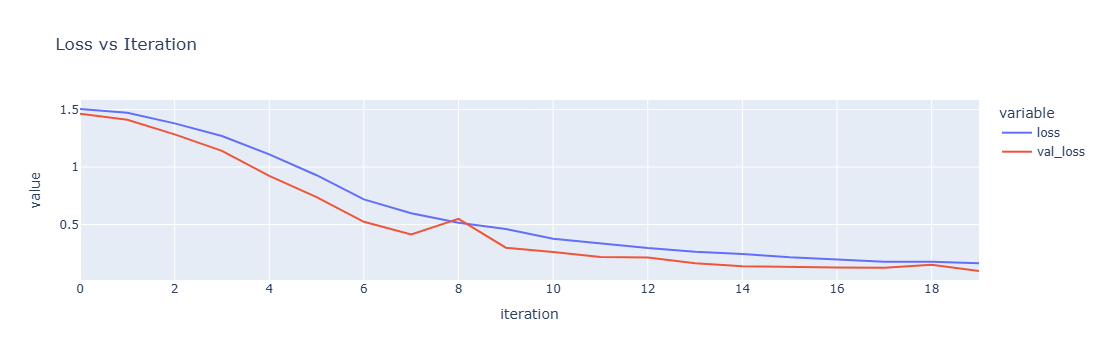

In [64]:
dfh = pd.DataFrame()
dfh['accuracy'] = history.history['accuracy']
dfh['loss'] = history.history['loss']
dfh['val_accuracy'] = history.history['val_accuracy']
dfh['val_loss'] = history.history['val_loss']
iterations = len(dfh)
dfh['iteration'] = range(0,iterations)
print("Number of iterations:",iterations)

display(dfh.style)
#
# ACCURACY
fig = px.line(dfh, x='iteration', y=['accuracy','val_accuracy'], title='Accuracy vs Iteration')
fig.show("plotly_mimetype")
#
# Loss
fig = px.line(dfh, x='iteration', y=['loss','val_loss'], title='Loss vs Iteration')
fig.show("plotly_mimetype")

In [74]:
# Get the individual model_m for each sample in the test set
predictions = model_cnn.predict(X_train)
#
# Remove code below for student version!
#
# Get the max probabilites for each rows
train_probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
train_preds = np.argmax(predictions, axis = 1)


# Get the individual model_m for each sample in the test set
predictions = model_cnn.predict(X_test)
#
# Remove code below for student version!
#
# Get the max probabilites for each rows
test_probs = np.max(predictions, axis = 1)
#
# Get the predicted classes for each row
test_preds = np.argmax(predictions, axis = 1)

63/63 [==============================] - 1s 8ms/step


In [68]:
def calc_performance_CNN(y_vals_true, y_vals_pred,labels,label_names={},max_letters_label=-1):
#
# Get the numbers for the confusion matrix
# To get output: cf_matrix[true_label,pred_label]
    cf_matrix = confusion_matrix(y_vals_true, y_vals_pred, labels=labels)
#
# This is a graphic
    cf_disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=labels)
#
# Make the header row
    header = [""]
    for column_name in labels:
        header.append('Pred:' + str(column_name))
    table = [header]
#
# Now make the rows with the matrix
    for row_name in labels:
        row_label = row_name
        if row_name in label_names:
            row_label = label_names[row_name]
            if max_letters_label > 0:
                row_label = row_label[:max_letters_label]
        row = ['True:'+str(row_label)]
        for column_name in labels:
            row_index = labels.index(row_name)
            column_index = labels.index(column_name)
            row.append(cf_matrix[row_index,column_index])
        table.append(row)
    # table = [
    #     [ "", "Predicted Class 1", "Precicted Class 0"],
    #     [ "True Class 1", TP, FN ],
    #     [ "True Class 0", FP, TN ]
    # ]
    print_table_type='fancy_grid'
    print_table = tabulate(table, headers='firstrow', tablefmt=print_table_type)
#    print(print_table)
#
# Get the recall, precision, ands F1 for each individual label
# - return both the "string report" (which you can print)
# - and the "dictionary report" (which you can use for averages and so on)
    report = classification_report(y_vals_true,y_vals_pred)
    report_dict = classification_report(y_vals_true,y_vals_pred,output_dict=True)
#
    results = {"confusionMatrix":cf_matrix,
                    'confusion_matrix_display':cf_disp,
                    'confusion_matrix_print_table':print_table,      
                    "report":report,"report_dict":report_dict}
    return results


In [77]:
severity_map = {0:'Most',
          1:'More',
          2:'Intermediate',
          3:'Less',
          4:'Least'}

In [78]:
results_test = calc_performance_CNN(y_test, test_preds,[0,1,2,3,4],severity_map,max_letters_label=10)

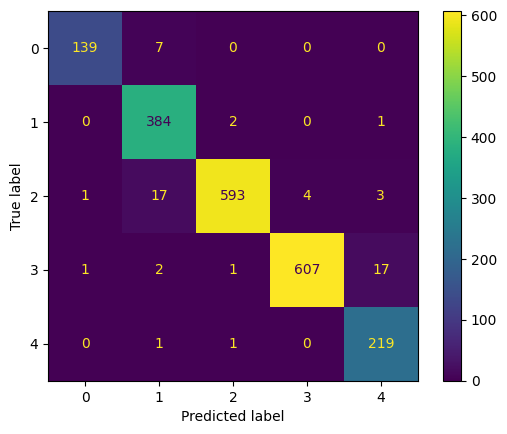

In [79]:
results_test['confusion_matrix_display'].plot()

In [84]:
results_train = calc_performance_CNN(y_train, train_preds,[0,1,2,3,4],severity_map,max_letters_label=12)

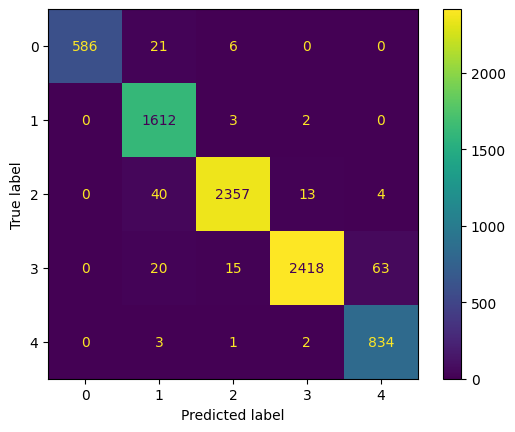

In [81]:
results_train['confusion_matrix_display'].plot()

In [85]:
print(results_train['confusion_matrix_print_table'])

╒═══════════════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│                   │   Pred:0 │   Pred:1 │   Pred:2 │   Pred:3 │   Pred:4 │
╞═══════════════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ True:Most         │      586 │       21 │        6 │        0 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:More         │        0 │     1612 │        3 │        2 │        0 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Intermediate │        0 │       40 │     2357 │       13 │        4 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Less         │        0 │       20 │       15 │     2418 │       63 │
├───────────────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ True:Least        │        0 │        3 │        1 │        2 │      834 │
╘═══════════════════╧══════════╧══════════╧══════════╧══════════╧══════════╛

In [65]:
printmem()

   memory: 13.764 Gbytes


In [89]:
df.severity = df.severity-1

In [92]:
df.head()

,AGE,SEX,E_0,E_1,E_10,E_100,E_101,E_102,E_103,E_104,...,E_98,E_99,E_132,E_134,E_136,E_56,E_58,E_59,severity,pathoClass
0,18,0,0,0,0,0,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.4,0.3,0.3,4,0
1,21,0,0,0,0,0,0,0,0,0,...,0,0,0.0,0.6,0.0,0.7,0.7,0.2,2,1
2,19,1,0,0,0,0,0,0,0,0,...,0,0,0.4,0.0,0.0,0.5,0.2,0.6,2,2
3,34,1,0,0,0,0,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.7,0.5,0.4,4,0
4,36,0,0,0,0,0,0,0,0,0,...,0,0,-1.0,-1.0,-1.0,0.5,0.4,0.2,4,0


In [93]:
df.to_csv('train_Normal.zip', index=False, compression='zip')